In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F

/home/ehsan/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Create Graph 

The famous Zachary Karate Club graph is loaded. This is a classic little social network graph where the nodes represent members of a karate club and the edges represent friendships between them. The club eventually split into two groups.
1. {'club': 'Mr. Hi'}
2. {'club': 'Officer'}

In [2]:
G = nx.karate_club_graph()
A = nx.to_numpy_array(G)
labels_true = np.array([G.nodes[i]['club'] == 'Mr. Hi' for i in G.nodes()], dtype=int)

###  2. Spectral Clustering

The normalized Laplacian is usually used because it gives better results. This is done with the formula $L_{sym}=D^{−1/2}LD^{−1/2}$ which helps in the stability of the algorithm.

In [11]:
def laplacian_matrix(A, normalized=True):
    D = np.diag(A.sum(axis=1))
    L = D - A
    if normalized:
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
        L = D_inv_sqrt @ L @ D_inv_sqrt
    return L

def spectral_clustering(A, k, normalized=True):
    L = laplacian_matrix(A, normalized)
    eigvals, eigvecs = np.linalg.eigh(L)
    X = eigvecs[:, :k]
    km = KMeans(n_clusters=k, n_init=10)
    labels = km.fit_predict(X)
    return labels

In [12]:
labels_spectral = spectral_clustering(A, k=2)

In [13]:
labels_spectral

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

### 3. Simple GCN by PyTorch

In [24]:

class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, X, A_hat):
        out = torch.mm(A_hat, X)
        out = self.linear(out)
        return out

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_feats)
        self.gcn2 = GCNLayer(hidden_feats, out_feats)

    def forward(self, X, A_hat):
        h = self.gcn1(X, A_hat)
        h = F.relu(h)
        h = self.gcn2(h, A_hat)
        return h

### 4. Prepare Data

We add self-loop to the adjacency matrix. That is, we add the identity matrix $I$ to the matrix $A$. This makes each node consider its own information when collecting information from its neighbors.

In [25]:
I = np.eye(A.shape[0])
A_hat = A + I
D_hat = np.diag(A_hat.sum(axis=1))
D_hat_inv_sqrt = np.linalg.inv(np.sqrt(D_hat))
A_hat_norm = D_hat_inv_sqrt @ A_hat @ D_hat_inv_sqrt
A_hat_norm = torch.FloatTensor(A_hat_norm)

Since nodes do not have any initial features, we use an identity matrix as a feature. This means that each node is represented by a unique one-hot vector.

In [26]:
X_feat = torch.eye(A.shape[0])  # one-hot features
y = torch.LongTensor(labels_true)

We split the data into two parts: train and test. The model is trained using only the labels of the first 20 nodes (idx_train) and tries to predict the labels of the remaining nodes.

In [27]:
idx_train = torch.arange(0, 20)
idx_test = torch.arange(20, A.shape[0])

In [28]:
model = GCN(in_feats=A.shape[0], hidden_feats=16, out_feats=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### Train 

In [30]:
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(X_feat, A_hat_norm)
    loss = F.cross_entropy(out[idx_train], y[idx_train])
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
            print(f" Epoch {epoch+1:02d} | Loss: {loss.item():.4f}")

 Epoch 10 | Loss: 0.3651
 Epoch 20 | Loss: 0.2693
 Epoch 30 | Loss: 0.1919
 Epoch 40 | Loss: 0.1281
 Epoch 50 | Loss: 0.0894
 Epoch 60 | Loss: 0.0659
 Epoch 70 | Loss: 0.0507
 Epoch 80 | Loss: 0.0398
 Epoch 90 | Loss: 0.0318
 Epoch 100 | Loss: 0.0257
 Epoch 110 | Loss: 0.0210
 Epoch 120 | Loss: 0.0174
 Epoch 130 | Loss: 0.0146
 Epoch 140 | Loss: 0.0124
 Epoch 150 | Loss: 0.0107
 Epoch 160 | Loss: 0.0093
 Epoch 170 | Loss: 0.0081
 Epoch 180 | Loss: 0.0072
 Epoch 190 | Loss: 0.0064
 Epoch 200 | Loss: 0.0057


### Predict

In [31]:
model.eval()
out = model(X_feat, A_hat_norm)
pred_gcn = out.argmax(dim=1).numpy()

### Compare Result 

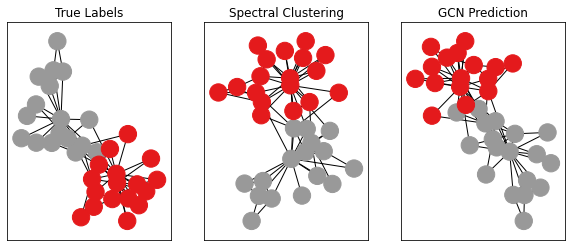

In [32]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
nx.draw_networkx(G, node_color=labels_true, with_labels=False, cmap=plt.cm.Set1)
plt.title("True Labels")

plt.subplot(1, 3, 2)
nx.draw_networkx(G, node_color=labels_spectral, with_labels=False, cmap=plt.cm.Set1)
plt.title("Spectral Clustering")

plt.subplot(1, 3, 3)
nx.draw_networkx(G, node_color=pred_gcn, with_labels=False, cmap=plt.cm.Set1)
plt.title("GCN Prediction")

plt.show()

In [33]:
labels_true

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
labels_spectral

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [35]:
pred_gcn

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

### Evalutaion

We evalute model with two metrics.
1. accuracy 
2. ARI [Adjusted Rand Index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)

In [44]:
from sklearn.metrics import accuracy_score, adjusted_rand_score

In [45]:
acc_spectral = accuracy_score(labels_true, labels_spectral)
ari_spectral = adjusted_rand_score(labels_true, labels_spectral)

In [46]:
acc_gcn = accuracy_score(labels_true, pred_gcn)
ari_gcn = adjusted_rand_score(labels_true, pred_gcn)

In [47]:
print("Spectral Clustering → Accuracy:", acc_spectral, " | ARI:", ari_spectral)
print("GCN                → Accuracy:", acc_gcn, " | ARI:", ari_gcn)

Spectral Clustering → Accuracy: 0.9705882352941176  | ARI: 0.8822575413558222
GCN                → Accuracy: 0.9705882352941176  | ARI: 0.8822575413558222
